In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [ ]:
import glob
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-06-14 05:13:16--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  4.12MB/s    in 32m 36s 

2023-06-14 05:45:54 (2.94 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [ ]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

In [ ]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [ ]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav


In [ ]:
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

In [ ]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata


def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [ ]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [ ]:
audio_statistics_df = compute_audio_statistics(dataset_df)

In [ ]:
audio_statistics_df.describe()

,salience,classID,length,bitrate,channels,sample_rate,bits_per_sample
count,8732.000000,8732.000000,8732.000000,8.732000e+03,8732.000000,8732.000000,8732.000000
mean,1.347000,4.592877,3.603644,1.800775e+06,1.915369,48456.979272,18.780119
std,0.476043,2.894544,0.980913,9.765852e+05,0.278348,15300.080707,4.227168
min,1.000000,0.000000,0.000816,4.409600e+04,1.000000,8000.000000,4.000000
25%,1.000000,2.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
50%,1.000000,4.000000,4.000000,1.411200e+06,2.000000,44100.000000,16.000000
75%,2.000000,7.000000,4.000000,2.116800e+06,2.000000,48000.000000,24.000000
max,2.000000,9.000000,4.000000,1.228800e+07,2.000000,192000.000000,32.000000


In [ ]:
# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

In [ ]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 1
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to car_horn sample


In [ ]:
audio_file, sample_rate = librosa.load(audio_samples[0])
stft = librosa.stft(audio_file)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)
S_db

(1025, 173)


array([[ -7.9470577,  -6.6493797, -30.962303 , ..., -15.80121  ,
        -11.990364 , -12.433817 ],
       [ -8.990086 ,  -8.675625 , -11.424343 , ..., -11.467707 ,
        -10.281643 , -13.835815 ],
       [-11.585678 , -15.733986 , -17.946932 , ..., -14.065266 ,
         -8.796789 , -16.975607 ],
       ...,
       [-80.       , -80.       , -80.       , ..., -80.       ,
        -76.08072  , -65.89273  ],
       [-80.       , -80.       , -80.       , ..., -80.       ,
        -76.084114 , -65.89501  ],
       [-80.       , -80.       , -80.       , ..., -80.       ,
        -76.08591  , -65.89548  ]], dtype=float32)

In [ ]:
audio_samples[:10]

['UrbanSound8K/audio/fold10/167464-0-0-16.wav',
 'UrbanSound8K/audio/fold10/28808-1-0-8.wav',
 'UrbanSound8K/audio/fold1/135776-2-0-90.wav',
 'UrbanSound8K/audio/fold8/103076-3-1-0.wav',
 'UrbanSound8K/audio/fold10/99192-4-0-20.wav',
 'UrbanSound8K/audio/fold10/118558-5-0-2.wav',
 'UrbanSound8K/audio/fold7/135527-6-12-0.wav',
 'UrbanSound8K/audio/fold10/162134-7-12-1.wav',
 'UrbanSound8K/audio/fold2/123688-8-0-18.wav',
 'UrbanSound8K/audio/fold7/89443-9-0-17.wav']

In [ ]:
t0 = librosa.load(audio_samples[0])
len(t0)

2

In [ ]:
max_pad_len = 174

def extract_feature(file_name):
    print('file name :', file_name)
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0,0), (0, pad_width)), mode='constant')
        print(mfccs.shape)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e);
        return None

#     return padded_mfccs
    return mfccs

In [ ]:
extract_feature(audio_samples[0])

file name : UrbanSound8K/audio/fold10/167464-0-0-16.wav
(40, 174)


array([[-2.0233733e+02, -1.7053358e+02, -1.7046239e+02, ...,
        -1.6320650e+02, -1.8560181e+02,  0.0000000e+00],
       [ 1.3650131e+02,  1.3925815e+02,  1.4162592e+02, ...,
         1.4080183e+02,  1.3599614e+02,  0.0000000e+00],
       [-2.2142822e+01, -1.9450180e+01, -1.6487972e+01, ...,
        -1.2779876e+01, -1.1411455e+01,  0.0000000e+00],
       ...,
       [ 6.0040021e+00, -9.7803360e-01, -2.1585507e+00, ...,
         1.3147953e-01,  2.6064887e+00,  0.0000000e+00],
       [ 4.9025469e+00, -2.8161895e+00, -7.0667715e+00, ...,
        -1.1809565e+00, -2.7818413e+00,  0.0000000e+00],
       [-2.0400591e+00, -4.9871473e+00, -8.8285393e-01, ...,
        -2.9550078e+00, -6.6438663e-01,  0.0000000e+00]], dtype=float32)

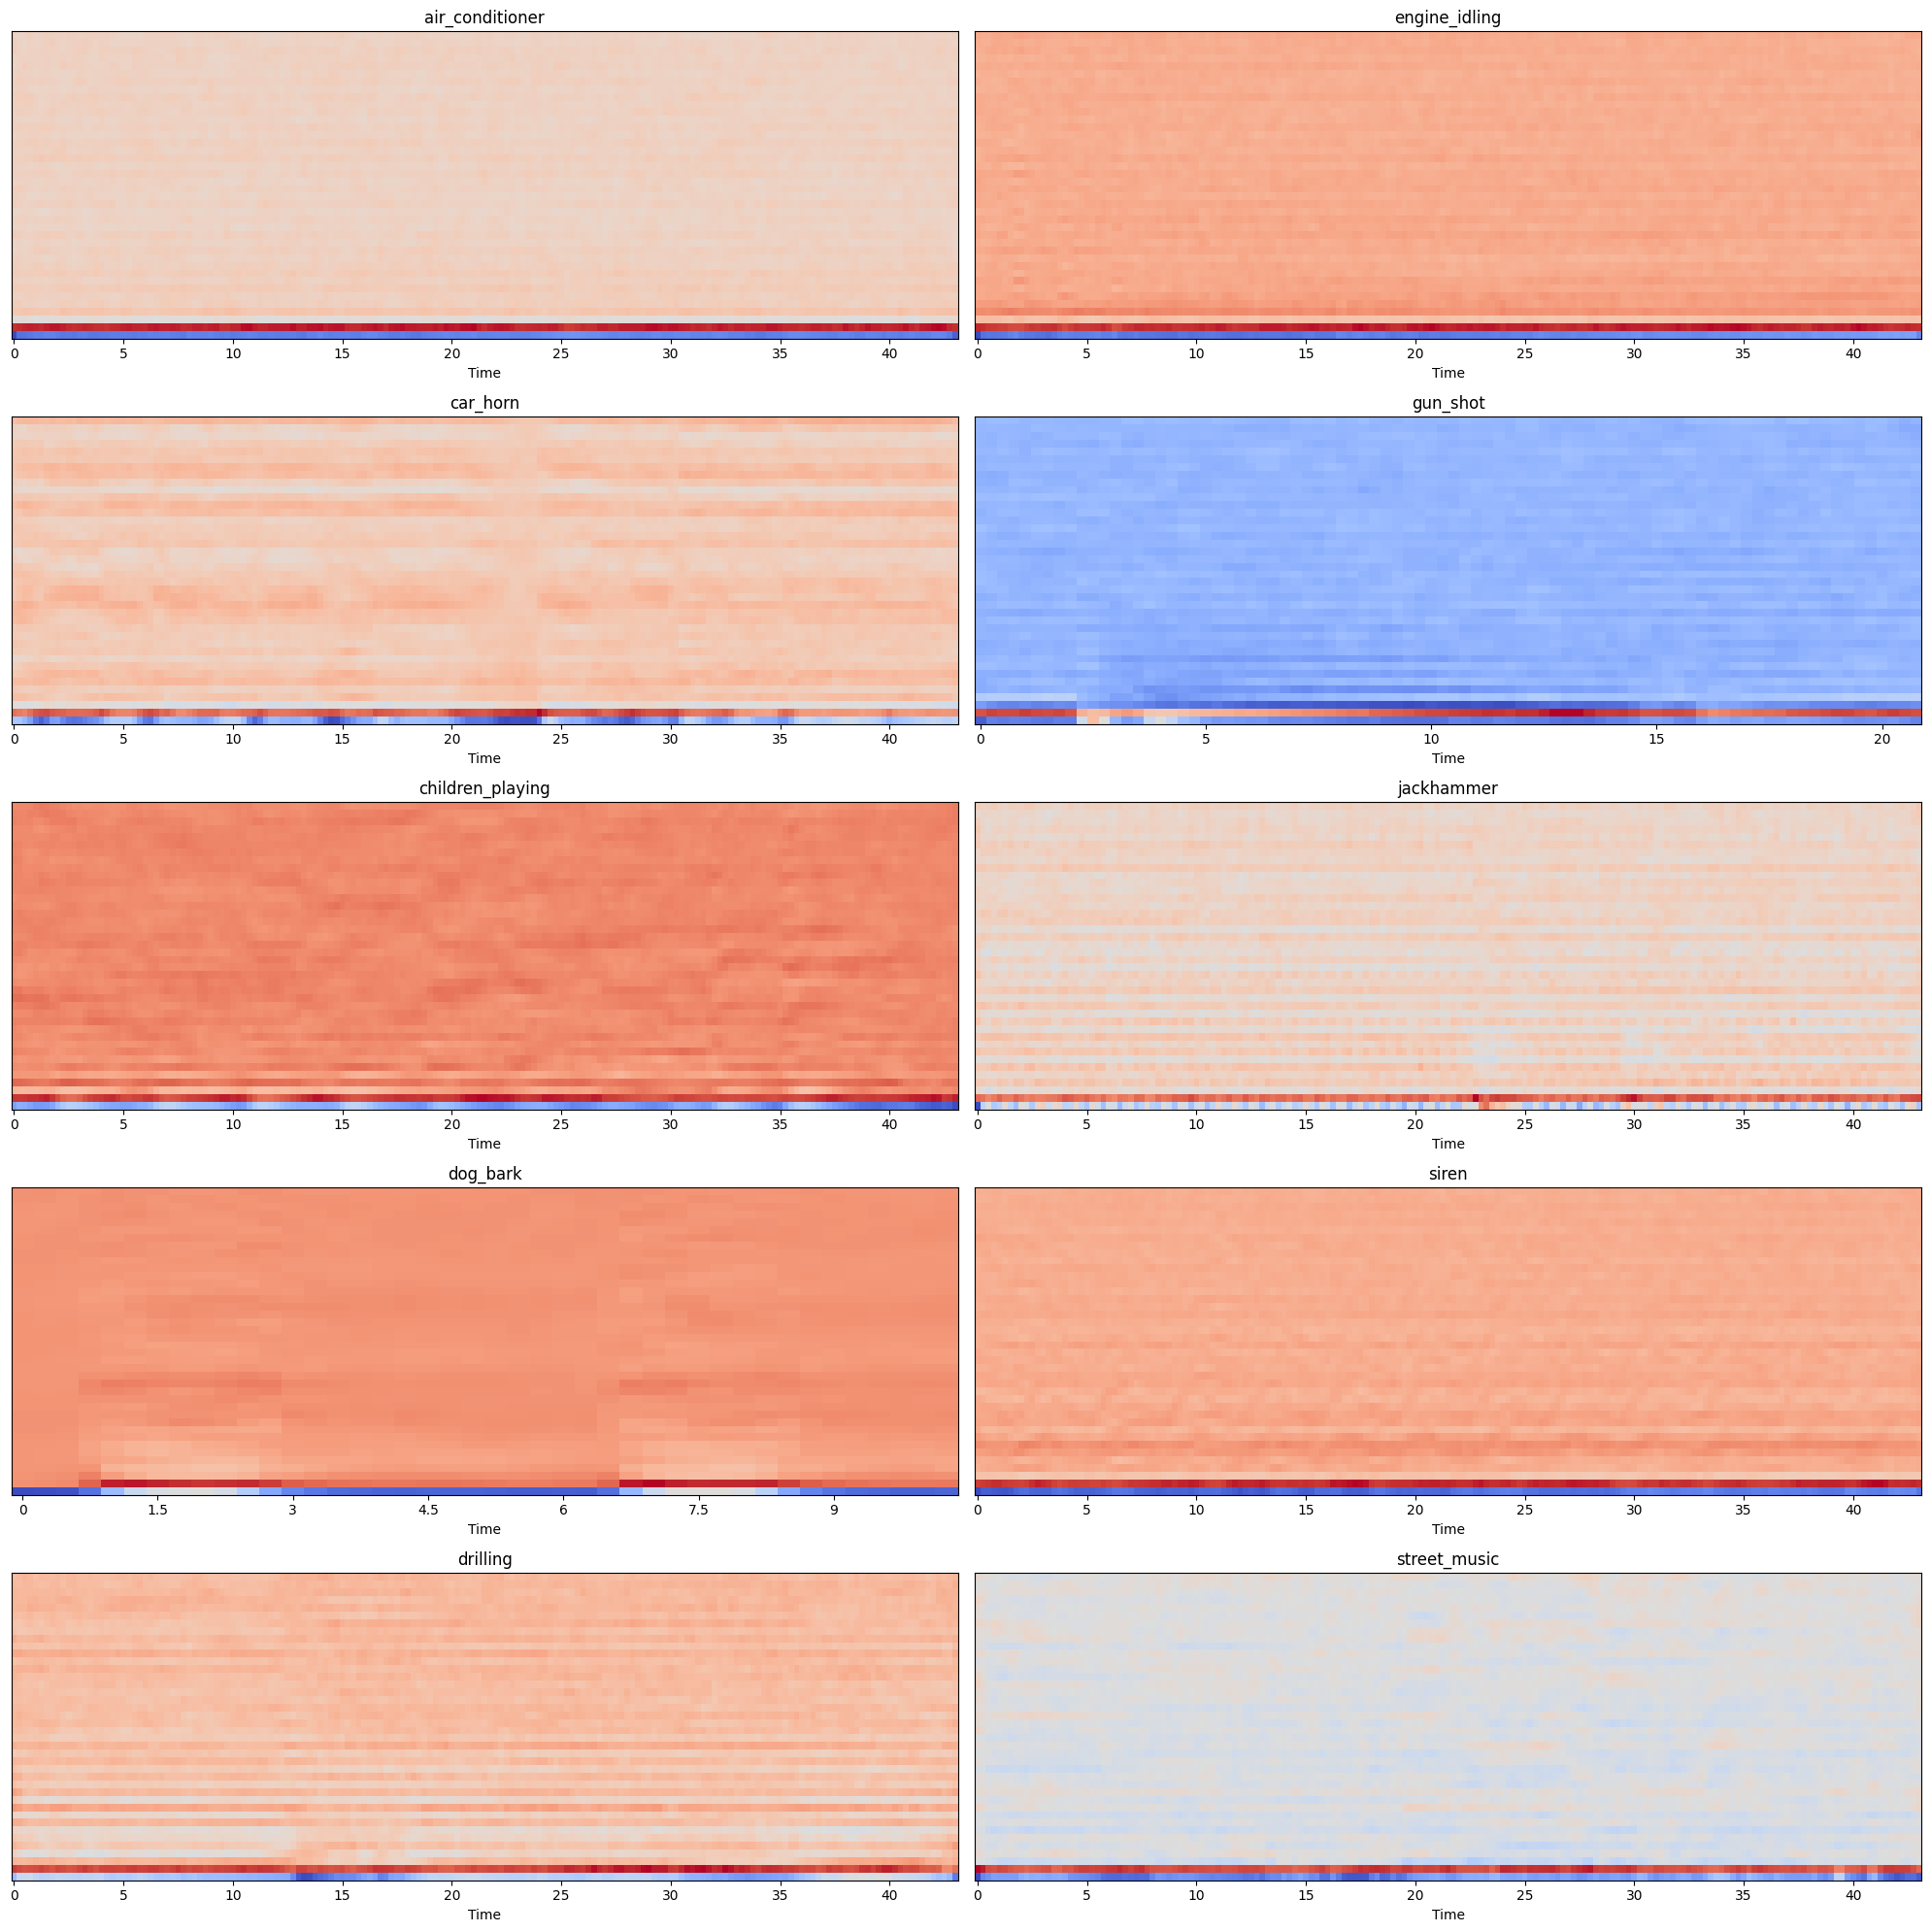

In [ ]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20,20))
index = 0
n_s = 4
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mfcc=40)
        librosa.display.specshow(mfccs,
                             sr=n_fft,
                             hop_length=hop_length,
                             x_axis="time",
                             ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()


In [ ]:
dataset_df

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,UrbanSound8K/audio/fold7/99812-1-2-0.wav
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,UrbanSound8K/audio/fold7/99812-1-3-0.wav
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,UrbanSound8K/audio/fold7/99812-1-4-0.wav
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,UrbanSound8K/audio/fold7/99812-1-5-0.wav


In [ ]:
##데이터 feature df로 만들기
# Set the path to the full UrbanSound dataset
metadata = dataset_df
features = []

# Iterate through each sound file and extract the features
for index, row in metadata.iterrows():
    file_name = row['filepath']
    class_label = row["classID"]
    data = extract_feature(file_name)

    features.append([data, class_label])

# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

Streaming output truncated to the last 5000 lines.
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-13.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-14.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-15.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-16.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-17.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-18.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-2.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-3.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-4.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-5.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-6.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-7.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-8.wav
(40, 174)
file name : UrbanSound8K/audio/fold6/124389-8-1-9.wav
(40, 174)
file name : UrbanSound8K/audio/fold1/

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Streaming output truncated to the last 5000 lines.
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-81.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-82.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-83.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-84.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-85.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-86.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-87.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-88.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-89.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-9.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-90.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-91.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-92.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8-0-93.wav
(40, 174)
file name : UrbanSound8K/audio/fold4/24347-8

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


(40, 174)
file name : UrbanSound8K/audio/fold10/88121-8-0-1.wav
(40, 174)
file name : UrbanSound8K/audio/fold10/88121-8-0-2.wav
(40, 174)
file name : UrbanSound8K/audio/fold10/88121-8-0-3.wav
(40, 174)
file name : UrbanSound8K/audio/fold10/88121-8-1-0.wav
(40, 174)
file name : UrbanSound8K/audio/fold10/88121-8-2-0.wav
(40, 174)
file name : UrbanSound8K/audio/fold1/88466-7-0-0.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-14.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-21.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-36.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-54.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-67.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-77.wav
(40, 174)
file name : UrbanSound8K/audio/fold3/88569-2-0-85.wav
(40, 174)
file name : UrbanSound8K/audio/fold7/89099-4-0-0.wav
(40, 174)
file name : UrbanSound8K/audio/fold7/89099-4-0-1.wav
(40, 174)
file name : UrbanSound8K/audio/fo

In [ ]:
# 피클로 데이터 저장
featuresdf.to_pickle("/content/drive/MyDrive/KT_aivle/bigproject/featuresdf.pkl")

# 피클 데이터 로드
featuresdf = pd.read_pickle("/content/drive/MyDrive/KT_aivle/bigproject/featuresdf.pkl")

In [ ]:
#X=이미지 feature, Y=class
from keras.utils import to_categorical

X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(6985, 40, 174) (1747, 40, 174) (6985, 10) (1747, 10)


In [ ]:
n_columns = 174
n_row = 40
n_channels = 1
n_classes = 10

# input shape 조정
x_train = tf.reshape(x_train, [-1, n_row, n_columns, n_channels])
x_test = tf.reshape(x_test, [-1, n_row, n_columns, n_channels])

In [ ]:
model = keras.Sequential()

model.add(layers.Conv2D(input_shape=(n_row, n_columns, n_channels), filters=16, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(kernel_size=2, filters=32, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(kernel_size=2, filters=64, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(kernel_size=2, filters=128, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.2))

model.add(layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 173, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [ ]:
training_epochs = 15
num_batch_size = 128

learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=training_epochs)

Epoch 1/15
55/55 [==============================] - 41s 728ms/step - loss: 1.4794 - accuracy: 0.4775
Epoch 2/15
55/55 [==============================] - 45s 790ms/step - loss: 1.2579 - accuracy: 0.5644
Epoch 3/15
55/55 [==============================] - 39s 719ms/step - loss: 1.1498 - accuracy: 0.5990
Epoch 4/15
55/55 [==============================] - 39s 704ms/step - loss: 1.0492 - accuracy: 0.6405
Epoch 5/15
55/55 [==============================] - 39s 703ms/step - loss: 0.9821 - accuracy: 0.6671
Epoch 6/15
55/55 [==============================] - 40s 724ms/step - loss: 0.8835 - accuracy: 0.7024
Epoch 7/15
55/55 [==============================] - 38s 679ms/step - loss: 0.8514 - accuracy: 0.7201
Epoch 8/15
55/55 [==============================] - 39s 716ms/step - loss: 0.7860 - accuracy: 0.7357
Epoch 9/15
55/55 [==============================] - 39s 714ms/step - loss: 0.7141 - accuracy: 0.7560
Epoch 10/15
55/55 [==============================] - 39s 715ms/step - loss: 0.6876 - accura

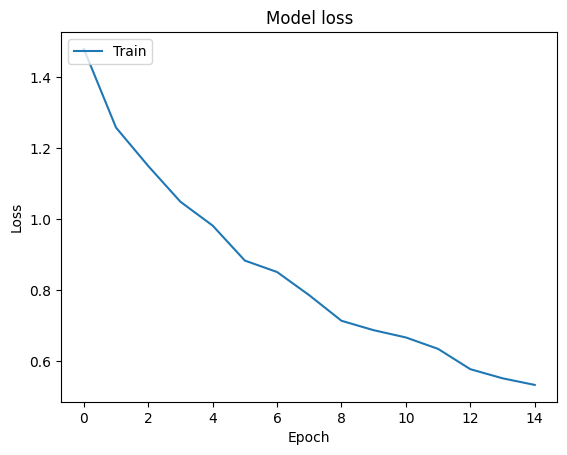

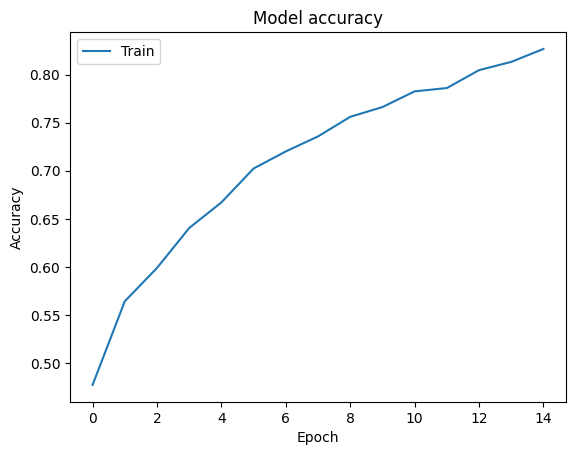

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [ ]:
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
14/14 [==============================] - 3s 172ms/step - loss: 0.6743 - accuracy: 0.7871
test loss, test acc: [0.6742669939994812, 0.7870635390281677]


In [ ]:
model.save("/content/drive/MyDrive/KT_aivle/bigproject/sound_classifier_model")